# Chess Tournament Analysis (CTA)
## Descripción
En este proyecto se busca hacer un analisis del torneo de Barcelona en especifico para luego poder escalarlo a otros torneos de ajedrez. Se busca analizar los datos de los jugadores, partidas y torneos para poder hacer un analisis de los jugadores y sus partidas.

## Objetivos
- Analizar los datos de los jugadores, partidas y torneos
- Realizar un analisis de los jugadores y sus partidas
- Realizar un analisis del torneo
- Analizar la evaluación del motor de ajedrez
- Analizar los movimientos más comunes
- Analizar las estrategias más comunes

## Datos
Los datos se encuentran en la carpeta `data` y se dividen en 3 archivos:
- `players.csv`: Contiene los datos de los jugadores
- `details.csv`: Contiene los datos de las partidas y la apertura realizada
- `moves.csv`: Contiene los datos de los movimientos, evaluación y tiempo de los movimientos
- `openings.csv`: Contiene los datos de las aperturas de ajedrez, el código de la apertura y el nombre de la apertura

## Estudios a realizar
- Rendimiento del jugador : Como se comporta el jugador en el torneo
- Efecto de la apertura en el resultado : Hay alguna apertura que sea mejor que otra para llegar a un mejor resultado
- Evaluación del motor de ajedrez : Como se comporta el motor de ajedrez en comparación con los jugadores profesionales
- Impacto del tiempo en el rendimiento : Cuanto influye el tiempo en el rendimiento del jugador
- Relación entre ELO y resultado : Existe una relación entre el ELO del jugador y el resultado obtenido
- Diferencia entre blancas y negras : Influencia de jugar con blancas o negras en el resultado


## Estudio de los datos
### Carga de los datos
Primero se cargan los datos de los jugadores, partidas, movimientos y aperturas.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

details_df = pd.read_csv("../data/details.csv")
moves_df = pd.read_csv("../data/moves.csv")
openings_df = pd.read_csv("../data/openings.csv")
players_df = pd.read_csv("../data/players.csv")

Segundo, se unen las tablas de jugadores con los detalles

In [54]:
players_df = players_df.drop_duplicates(subset=["FideId"])

details_df = details_df.merge(players_df, left_on="White", right_on="FideId", suffixes=("_white", "_player"))
details_df = details_df.merge(players_df, left_on="Black", right_on="FideId", suffixes=("", "_black"))
details_df = details_df.rename(columns={"Name": "White_Player", "Name_black": "Black_Player",
                                        "Elo": "White_Elo", "Elo_black": "Black_Elo"})

openings_df = openings_df.drop_duplicates(subset=["ECO"])
details_df = details_df.merge(openings_df, on="ECO", how="left")
details_df = details_df.drop_duplicates()


In [42]:
def moves_data_transform():
    moves_df["Round"] = moves_df["Round"].astype(str)
    moves_df["Move Number"] = moves_df["Move Number"].astype(int)
    moves_df["Move"] = moves_df["Move"].astype(str)
    moves_df["Color"] = moves_df["Color"].astype(str)
    moves_df["Evaluation"] = pd.to_numeric(moves_df["Evaluation"], errors="coerce")
    moves_df["Time"] = moves_df["Time"].astype(str)
    moves_df["Time (seconds)"] = pd.to_numeric(moves_df["Time (seconds)"], errors="coerce").fillna(0).astype(int)

moves_data_transform()

### Gráficas básicas
#### 1. Rendimiento de los jugadores

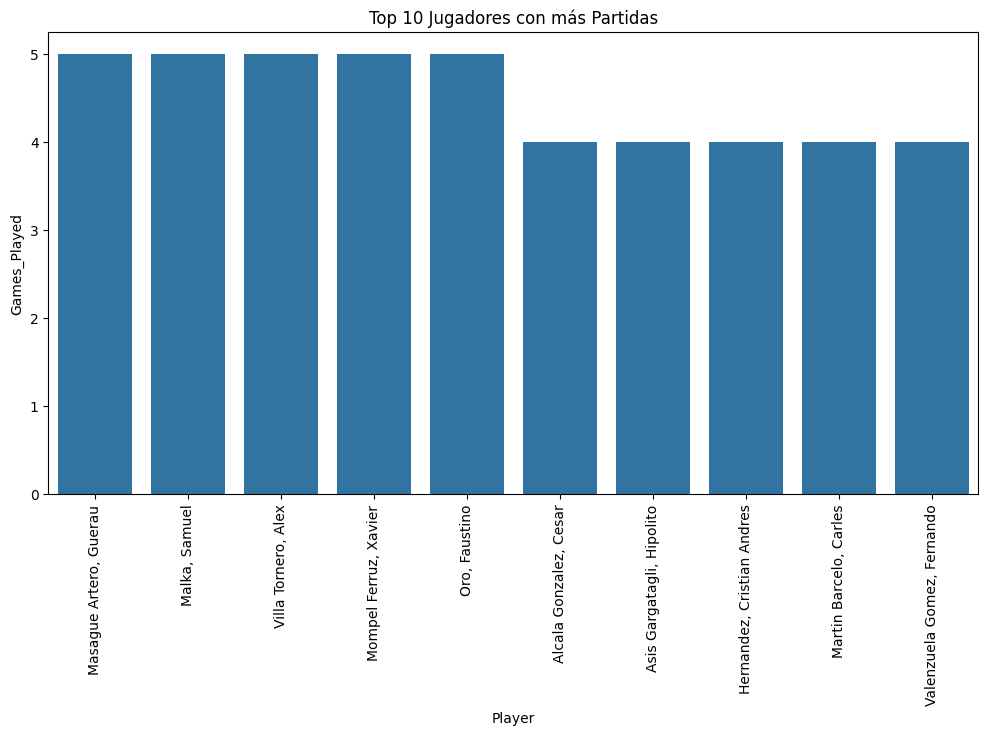

In [43]:
def player_performance():
    player_results = details_df.groupby("White_Player")["White_Elo"].count().reset_index()
    player_results.columns = ["Player", "Games_Played"]
    plt.figure(figsize=(12, 6))
    sns.barplot(data=player_results.sort_values("Games_Played", ascending=False).head(10), x="Player", y="Games_Played")
    plt.xticks(rotation=90)
    plt.title("Top 10 Jugadores con más Partidas")
    plt.show()

player_performance()

#### 2. Efecto de la apertura en el resultado

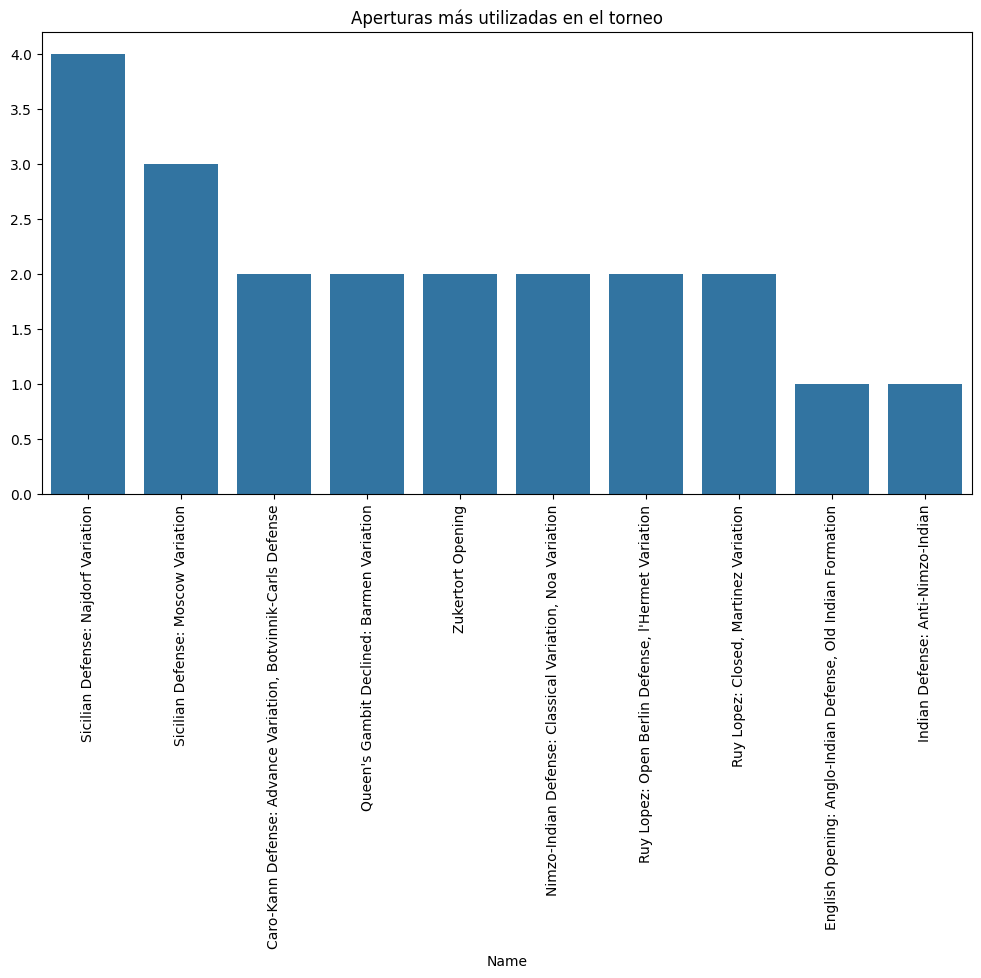

In [44]:
def opening_effect():
    opening_counts = details_df["Name"].value_counts().head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=opening_counts.index, y=opening_counts.values)
    plt.xticks(rotation=90)
    plt.title("Aperturas más utilizadas en el torneo")
    plt.show()

opening_effect()

#### 3. Evaluación del motor de ajedrez

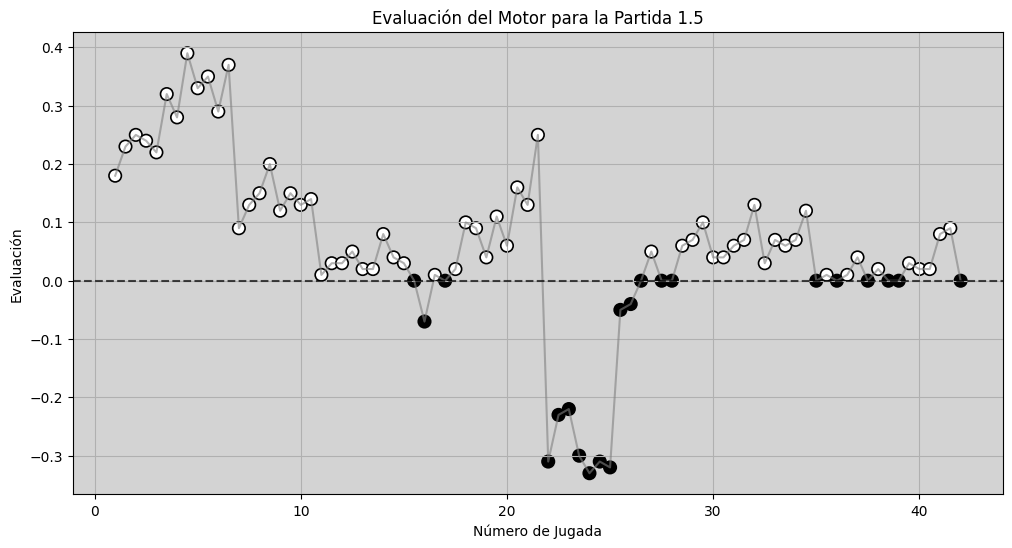

In [ ]:
import matplotlib.pyplot as plt

def engine_evaluation(round_number):
    game_moves = moves_df[moves_df["Round"] == round_number].copy()

    game_moves["Color Order"] = game_moves["Color"].map({"White": 0, "Black": 1})
    game_moves = game_moves.sort_values(by=["Move Number", "Color Order"]).drop(columns=["Color Order"])

    game_moves["Adjusted Move Number"] = game_moves["Move Number"] + game_moves["Color"].map({"White": 0, "Black": 0.5})

    move_numbers = game_moves["Adjusted Move Number"]
    evaluations = game_moves["Evaluation"]
    colors = ["white" if eval > 0 else "black" for eval in evaluations]

    plt.figure(figsize=(12, 6))
    plt.plot(move_numbers, evaluations, linestyle='-', color='gray', alpha=0.6)
    plt.scatter(move_numbers, evaluations, c=colors, edgecolors="black", s=80, linewidth=1.2)

    plt.axhline(0, color="black", linestyle="--", alpha=0.7)

    last_move = int(game_moves["Move Number"].max())

    last_tick = (last_move // 10 + 1) * 10
    if last_tick > last_move:
        last_tick = last_move + 1

    plt.xticks(range(0, last_tick + 1, 10))

    plt.title(f"Evaluación del Motor para la Partida {round_number}")
    plt.xlabel("Número de Jugada")
    plt.ylabel("Evaluación")
    plt.grid()
    plt.gca().set_facecolor("lightgray")

    plt.show()

engine_evaluation("1.5")


#### 4. Impacto del tiempo en el rendimiento

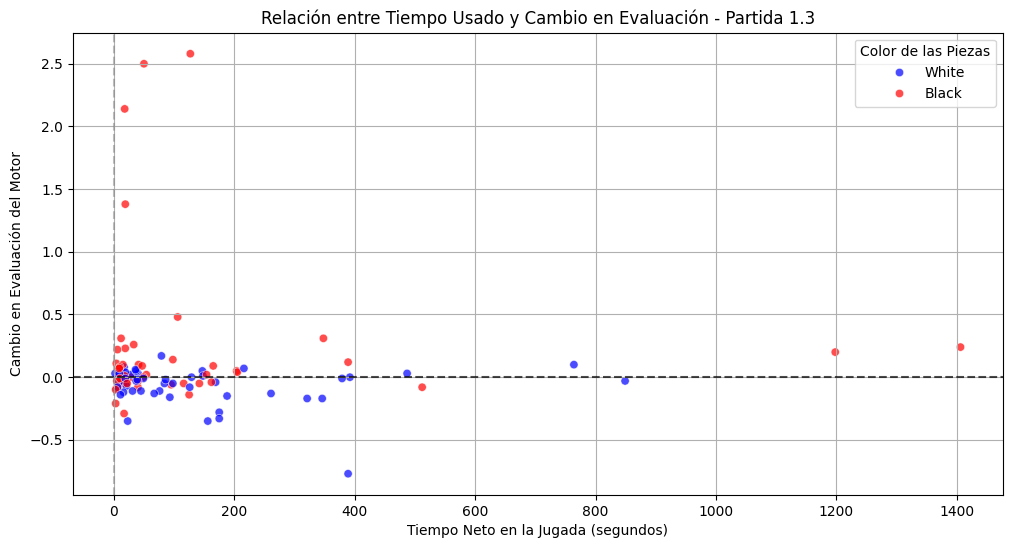

In [46]:
def time_vs_eval_change_single_game(moves_df, round_number):
    game_moves = moves_df[moves_df["Round"] == round_number].copy()

    game_moves["Time (seconds)"] = pd.to_numeric(game_moves["Time (seconds)"], errors="coerce")
    game_moves.dropna(subset=["Evaluation", "Time (seconds)"], inplace=True)

    game_moves["Time Net"] = game_moves["Time (seconds)"] - 30
    game_moves["Time Net"] = game_moves["Time Net"].apply(lambda x: max(x, 0))

    game_moves["Color Order"] = game_moves["Color"].map({"White": 0, "Black": 1})
    game_moves.sort_values(by=["Move Number", "Color Order"], inplace=True)
    game_moves.drop(columns=["Color Order"], inplace=True)

    game_moves["Time Difference"] = - (game_moves["Time Net"] - game_moves.groupby("Color")["Time (seconds)"].shift(1))

    game_moves["Eval Change"] = game_moves["Evaluation"].diff()

    game_moves.dropna(subset=["Time Difference", "Eval Change"], inplace=True)
    
    plt.figure(figsize=(12, 6))
    sns.scatterplot(
        data=game_moves, 
        x="Time Difference", 
        y="Eval Change", 
        hue="Color", 
        alpha=0.7, 
        palette={"White": "blue", "Black": "red"}
    )

    plt.axhline(0, color="black", linestyle="--", alpha=0.7)
    plt.axvline(0, color="gray", linestyle="--", alpha=0.5)
    plt.title(f"Relación entre Tiempo Usado y Cambio en Evaluación - Partida {round_number}")
    plt.xlabel("Tiempo Neto en la Jugada (segundos)")
    plt.ylabel("Cambio en Evaluación del Motor")
    plt.grid(True)
    plt.legend(title="Color de las Piezas")

    plt.show()

time_vs_eval_change_single_game(moves_df, "1.3")


#### 5. Relación entre ELO y resultado

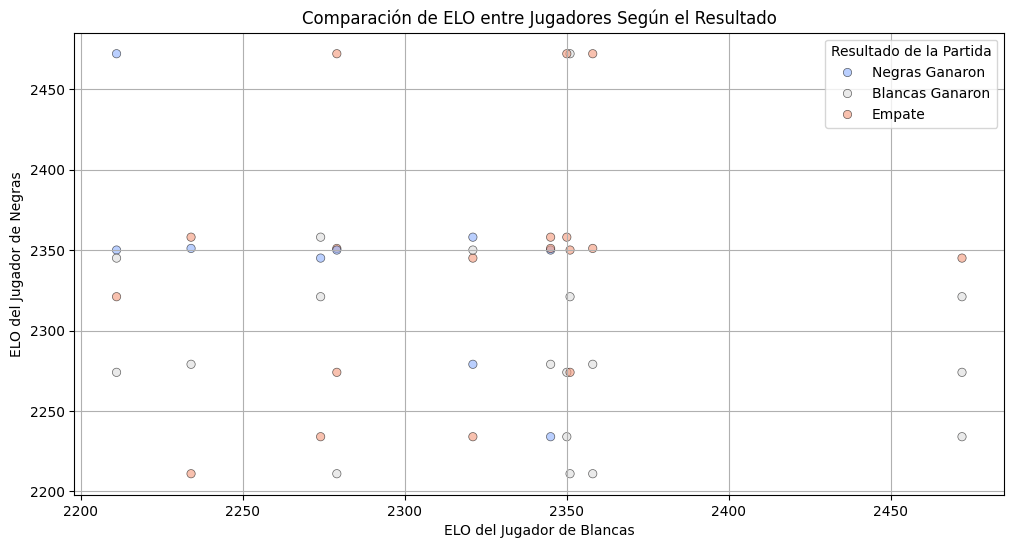

In [47]:
def elo_vs_result():
    details_df_clean = details_df.dropna(subset=["Result"])

    details_df_clean['Result'] = details_df_clean['Result'].map({'1-0': 'Blancas Ganaron', '0-1': 'Negras Ganaron', '1/2-1/2': 'Empate'})

    details_df_clean = details_df_clean[['White_Elo', 'Black_Elo', 'Result']]

    plt.figure(figsize=(12, 6))

    sns.scatterplot(data=details_df_clean, x="White_Elo", y="Black_Elo", hue="Result", palette="coolwarm", alpha=0.6, 
                    edgecolor="black", linewidth=0.5)

    plt.title("Comparación de ELO entre Jugadores Según el Resultado")
    plt.xlabel("ELO del Jugador de Blancas")
    plt.ylabel("ELO del Jugador de Negras")
    plt.legend(title="Resultado de la Partida")
    plt.grid(True)

    plt.show()

elo_vs_result()

#### 6. Diferencia entre blancas y negras

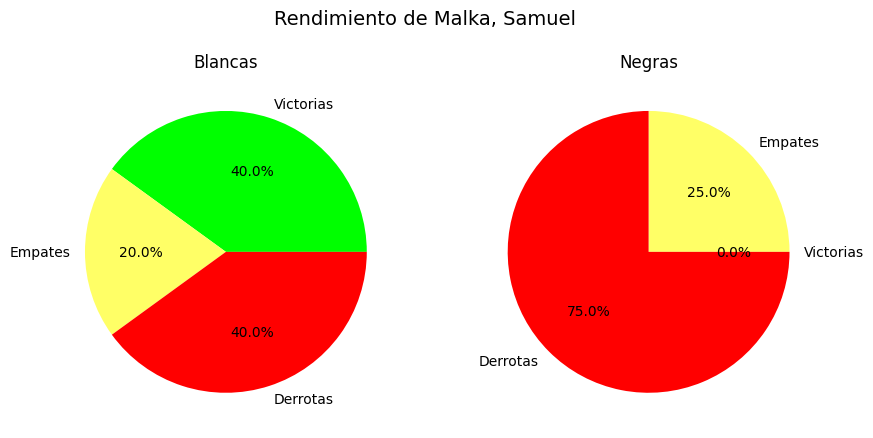

In [53]:
def player_color_advantage(player_name):
    white_games = details_df[details_df["White_Player"] == player_name]
    black_games = details_df[details_df["Black_Player"] == player_name]
    white_wins = (white_games["Result"] == "1-0").sum()
    white_losses = (white_games["Result"] == "0-1").sum()
    white_draws = (white_games["Result"] == "1/2-1/2").sum()

    black_wins = (black_games["Result"] == "0-1").sum()
    black_losses = (black_games["Result"] == "1-0").sum()
    black_draws = (black_games["Result"] == "1/2-1/2").sum()

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.pie([white_wins, white_draws, white_losses], labels=["Victorias", "Empates", "Derrotas"], 
            autopct="%.1f%%", colors=["#00FF00", "#FFFF66", "#FF0000"])
    plt.title(f"Blancas")

    plt.subplot(1, 2, 2)
    plt.pie([black_wins, black_draws, black_losses], labels=["Victorias", "Empates", "Derrotas"], 
            autopct="%.1f%%", colors=["#00FF00", "#FFFF66", "#FF0000"])
    plt.title(f"Negras")

    plt.suptitle(f"Rendimiento de {player_name}", fontsize=14)
    plt.show()

player_color_advantage("Malka, Samuel")


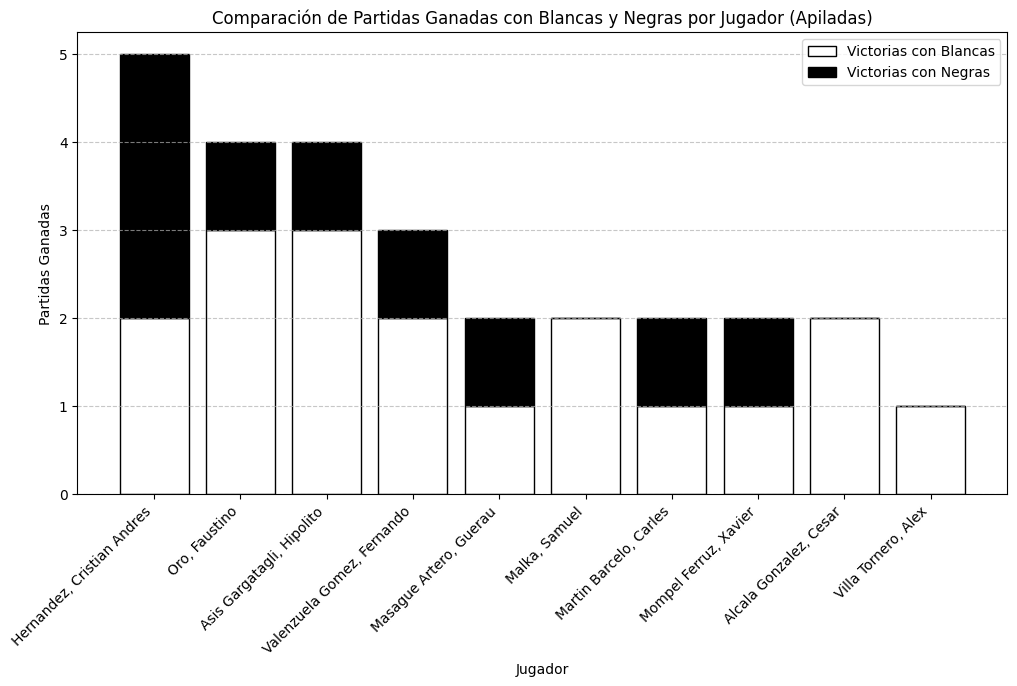

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def players_wins_comparison(details_df):
    players = pd.concat([details_df["White_Player"], details_df["Black_Player"]]).unique()
    stats_list = []

    for player in players:
        white_wins = ((details_df["White_Player"] == player) & (details_df["Result"] == "1-0")).sum()
        black_wins = ((details_df["Black_Player"] == player) & (details_df["Result"] == "0-1")).sum()

        stats_list.append({"Player": player, "Wins with White": white_wins, "Wins with Black": black_wins})

    players_stats = pd.DataFrame(stats_list)

    players_stats["Total Wins"] = players_stats["Wins with White"] + players_stats["Wins with Black"]
    players_stats = players_stats.sort_values(by="Total Wins", ascending=False)

    x = np.arange(len(players_stats))

    plt.figure(figsize=(12, 6))
    plt.bar(x, players_stats["Wins with White"], color="white", edgecolor="black", label="Victorias con Blancas")
    plt.bar(x, players_stats["Wins with Black"], bottom=players_stats["Wins with White"], color="black", edgecolor="black", label="Victorias con Negras")

    plt.xlabel("Jugador")
    plt.ylabel("Partidas Ganadas")
    plt.title("Comparación de Partidas Ganadas con Blancas y Negras por Jugador (Apiladas)")
    plt.xticks(ticks=x, labels=players_stats["Player"], rotation=45, ha="right")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.show()

players_wins_comparison(details_df)
